In [1]:
import math
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import special
from scipy.optimize import brentq

%matplotlib inline
R = 10.73146 # Universal gas constant, psia-ft3/R-lbm mol

Step By Step worked Appendix C Example up to regression
Developing a complete fluid characterization for a gas-condensate fluid, including the splitting of C7+ into five fractions, determining volume-translation coefficients for the C7+ fractions, and estimating methane through C7+ binary interaction parameters (BIP’s)

In [2]:
#Following parameters are assumed for this example
alpha = 1      # Sets the shape of the gamma distribution
eta = 90         # Can also be estimated with Eq 5.15 as = 110*(1-(1/(1+(4/alpha**0.7)))) 
 # Note: Eq 5.15 in the Monograph equation has a typo, and should be as Eq 21 in original paper in Chem. Eng. Comm 'Application of the Gamma Distribution Model to Molecular Weight and Boiling Point Data for Petroleum Fractions' (1990, vol 96, pp 259-278, C. Whitson et al)
N = 5          # Number of C7+ lumped components
MC7p = 143     # Average MW of C7+ components
GammaC7p = 0.795 # Can be estimated with Eq 5.37, where ZC7+ is molar fraction of C7+ components
MN = 500       # Heaviest fraction molecular weight. Recommended 2.5 x M7+
zC7p = 6.85  # Molar percentage of C7+ components, as defined in Table 6.5 for this example
quadrature = np.polynomial.laguerre.laggauss(N) # Calculates variables and weight factors - returns arrays of results
XN = quadrature[0][-1] # Return the last quadrature function variable
beta_star = (MN - eta)/XN         # Gamma function parameter (not a relationship to tune) - Page 76, step 3
d = math.exp((alpha*beta_star)/(MC7p-eta)-1) # Eq 5.30

In [3]:
f, z, M  = ([] for i in range(3))
for i, x in enumerate(quadrature[0]):
    f.append(x**(alpha-1)*(1+math.log(d))**alpha/(scipy.special.gamma(alpha)*d**x)) #Eq 5.31
    z.append(zC7p*quadrature[1][i]*f[-1]) #Eq preceeding Eq 5.31
    M.append(eta + beta_star*x)           #Eq preceeding Eq 5.31

In [4]:
print('Table C-1 Comparison')
header=['C7+ Frac', 'Quad Point', 'Quad Weight', 'f(x)', 'Mole %', 'Mol Weight', 'Mass','z']
table = []
for i in range(N):
    table.append([i+1,quadrature[0][i],quadrature[1][i],f[i], z[i],M[i],z[i]*M[i],z[i]])
print(tabulate(table,headers=header))

Table C-1 Comparison
  C7+ Frac    Quad Point    Quad Weight       f(x)     Mole %    Mol Weight       Mass          z
----------  ------------  -------------  ---------  ---------  ------------  ---------  ---------
         1       0.26356     0.521756     0.677872  2.42273         98.5485  238.757    2.42273
         2       1.4134      0.398667     1.05905   2.89212        135.843   392.875    2.89212
         3       3.59643     0.0759424    2.47055   1.28519        206.649   265.584    1.28519
         4       7.08581     0.00361176   9.56786   0.236714       319.826    75.7073   0.236714
         5      12.6408      2.337e-05   82.5899    0.0132213      500         6.61067  0.0132213


In [5]:
def ExpGammaC7p(Cf, zC7p, MC7p, z, M): # Calculates equations 5.44 and 5.37 to return experimental Gamma C7+ for a defined Cf
    gamma = []
    denominator = 0
    for i, m in enumerate(M):
        gamma.append(0.2855 + Cf * (m-66)**0.13)  #Eq 5.44
        denominator += z[i]*M[i]/gamma[-1]
    return zC7p*MC7p/denominator
        
def Cf_solver(GammaC7p, zC7p, MC7p, z, M ): # Iteratively solves system of Equations 5.44 and 5.37 to satisfy target Gamma_C7+
    tol = 0.0001 # Relative error tolerance permitted in experimental Gamma C7+
    Cf_test = [0.1,1] # Starting point low/high Cf values to test - the response is quite linear for this example at least, so using simple linear method
    err = [ExpGammaC7p(item, zC7p, MC7p, z, M) - GammaC7p for item in Cf_test]
    while abs(min(err, key=abs))/GammaC7p > tol:
        err_slope = (err[1]-err[0])/(Cf_test[1]-Cf_test[0])
        err_intcpt = err[0]-err_slope*Cf_test[0]
        new_cf = -err_intcpt / err_slope
        if abs(Cf_test[0]-new_cf) <= abs(Cf_test[1]-new_cf): #Keep [0] and replace [1] with new Cf value
            Cf_test[1] = new_cf
            err[1] = ExpGammaC7p(new_cf, zC7p, MC7p, z, M) - GammaC7p
        else:
            Cf_test[0] = new_cf                         #Keep [1] and replace [0] with new Cf value
            err[0] = ExpGammaC7p(new_cf, zC7p, MC7p, z, M) - GammaC7p
            
    min_err = min(err, key=abs)
    min_idx = err.index(min_err)
    return Cf_test[min_idx] 
        

In [6]:
Cf = Cf_solver(GammaC7p, zC7p, MC7p, z, M )
print('Solved Cf=',Cf)

Solved Cf= 0.2892617604486821


In [7]:
# Now (re)calculate specific gravities (gamma_i) and Boiling points (Tb) with the solved Cf
gamma = []
Tb = []
for i, m in enumerate(M):
    gamma.append(0.2855 + Cf * (m-66)**0.13)  #Eq 5.44
    Tb.append(1928.3-(1.695e5*m**-0.03522*gamma[-1]**3.266)*math.exp(-(4.922e-3*m)-4.7685*gamma[-1]+(3.462e-3*m*gamma[-1]))) # Eq 5.45


In [8]:
print('Table C-2 Comparison')
header=['C7+ Comp', 'Mol Weight', 'Mass', 'SG', 'Ideal Vol', 'Boiling Point']
table = []
for i in range(N):
    table.append([i+1,M[i],z[i]*M[i],gamma[i], z[i]*M[i]/gamma[i], Tb[i]])
print(tabulate(table,headers=header))

Table C-2 Comparison
  C7+ Comp    Mol Weight       Mass        SG    Ideal Vol    Boiling Point
----------  ------------  ---------  --------  -----------  ---------------
         1       98.5485  238.757    0.740404    322.468            674.12
         2      135.843   392.875    0.787874    498.653            793.87
         3      206.649   265.584    0.835736    317.784            972.682
         4      319.826    75.7073   0.879629     86.0673          1175.46
         5      500         6.61067  0.922537      7.16575         1386.34


In [9]:
#  --------------------
# Calculation of critical properties for the C7+ fractions using Twu method
# ---------------------------

Tcp, alpha, gamma_p, dGammaT, ft, Tc, Vcp, dGammaV, fv, vc, Pcp, dGammaP, fp, Pc   = ([] for i in range(14))

for i in range(N):
    Tcp.append(Tb[i]/(0.533272+(0.191017e-3*Tb[i])+(0.779681e-7*Tb[i]**2)-(0.284376e-10*Tb[i]**3)+(0.959468e2/(0.01*Tb[i]**13)))) # Eq 5.67
    alpha.append(1-(Tb[i]/Tcp[i]))                                                                       # Eq 5.72
    gamma_p.append(0.843593-0.128624*alpha[i]-3.36159*alpha[i]**3-13749.5*alpha[i]**12)                  # Eq 5.70
    dGammaT.append(math.exp(5*(gamma_p[i]-gamma[i]))-1)                                                  # Eq 5.75
    ft.append(dGammaT[-1]*((-0.362456/Tb[i]**0.5)+((0.0398285-(0.948125/Tb[i]**0.5))*dGammaT[-1])))      # Eq 5.75
    Tc.append(Tcp[-1]*((1+2*ft[-1])/(1-2*ft[-1]))**2)                                                    # Eq 5.75
    Vcp.append((1-(0.419869-0.505839*alpha[-1]-1.56436*alpha[-1]**3-9481.7*alpha[-1]**14))**-8)          # Eq 5.69
    dGammaV.append(math.exp(4*(gamma_p[i]**2-gamma[i]**2))-1)                                            # Eq 5.76
    fv.append(dGammaV[-1]*((0.466590/Tb[i]**0.5)+((-0.182421+(3.01721/Tb[i]**0.5))*dGammaV[-1])))        # Eq 5.76
    vc.append(Vcp[-1]*((1+2*fv[-1])/(1-2*fv[-1]))**2)                                                    # Eq 5.76
    Pcp.append((3.83354+1.19629*alpha[-1]**0.5+34.8888*alpha[-1]+36.1952*alpha[-1]**2+104.193*alpha[-1]**4)**2) # Eq 5.68
    dGammaP.append(math.exp(0.5*(gamma_p[i]-gamma[i]))-1)                                                # Eq 5.77
    fp.append(dGammaP[-1]*((2.53262-(46.1955/Tb[i]**0.5)-0.00127885*Tb[i])+(-11.4277+(252.14/Tb[i]**0.5)+0.00230535*Tb[i])*dGammaP[-1])) # Eq 5.77
    Pc.append(Pcp[-1]*(Tc[-1]/Tcp[-1])*(Vcp[-1]/vc[-1])*(((1+2*fp[-1])/(1-2*fp[-1]))**2))

In [10]:
print('Table C-3 Comparison')
header=['C7+ Comp', 'Tb', 'Tcp', 'Alpha', 'SGp', 'SG', 'dSGt', 'ft', 'Tc']
table = []
for i in range(N):
    table.append([i+1,Tb[i], Tcp[i], alpha[i], gamma_p[i], gamma[i], dGammaT[i], ft[i], Tc[i]])
print(tabulate(table,headers=header))
print('')
header=['C7+ Comp', 'vcp', 'dSGv', 'fv', 'vc', 'Pcp', 'dSGp', 'fp', 'Pc']
table = []
for i in range(N):
    table.append([i+1,Vcp[i], dGammaV[i], fv[i], vc[i], Pcp[i], dGammaP[i], fp[i], Pc[i]])
print(tabulate(table,headers=header))

Table C-3 Comparison
  C7+ Comp        Tb       Tcp     Alpha       SGp        SG       dSGt          ft       Tc
----------  --------  --------  --------  --------  --------  ---------  ----------  -------
         1   674.12    978.744  0.31124   0.690847  0.740404  -0.219472  0.00322334  1004.31
         2   793.87   1102.87   0.280176  0.730406  0.787874  -0.249743  0.00359806  1135.07
         3   972.682  1268.71   0.233333  0.770518  0.835736  -0.278258  0.00396382  1309.59
         4  1175.46   1434.63   0.180652  0.800521  0.879629  -0.326682  0.00475288  1490.23
         5  1386.34   1589.54   0.127835  0.820128  0.922537  -0.400732  0.00620769  1670.47

  C7+ Comp       vcp       dSGv           fv        vc       Pcp        dSGp          fp       Pc
----------  --------  ---------  -----------  --------  --------  ----------  ----------  -------
         1   6.90024  -0.247018  -0.00847927   6.44765  393.772   -0.024474   0.00256315  441.379
         2   9.32889  -0.294613  

In [11]:
# Acentric factor calculations
w, Tbr, Kw =  ([] for i in range(3))
A = [0, -5.9214, 6.09648, 1.28862, -0.169347, 15.2518, -15.6875, -13.4721, 0.43577]
for i in range(N):
    Tbr.append(Tb[i]/Tc[i])
    Kw.append(Tb[i]**(1/3)/gamma[i])
    if Tbr[i] < 0.8: # Use Lee-Kesler Eq 5.60
        w.append((-math.log(Pc[i]/14.7)+A[1]+A[2]/Tbr[i]+A[3]*math.log(Tbr[i])+A[4]*Tbr[i]**6)/(A[5]+A[6]/Tbr[i]+A[7]*math.log(Tbr[i])+A[8]*Tbr[i]**6)) # Eq 5.60
    else: # Use Kesler-Lee Eq 5.61
        w.append(-7.904+0.1352*Kw[i]-0.007465*Kw[i]**2+8.359*Tbr[i]+((1.408-0.01063*Kw[i])/Tbr[i])) # Eq 5.61

In [12]:
print('Table C-4 Comparison')
header=['C7+ Comp', 'Tb/Tc', 'Kw', 'w']
table = []
for i in range(N):
    table.append([i+1,Tbr[i], Kw[i], w[i]])
print(tabulate(table,headers=header))

Table C-4 Comparison
  C7+ Comp     Tb/Tc       Kw         w
----------  --------  -------  --------
         1  0.671226  11.8425  0.284244
         2  0.6994    11.7524  0.385637
         3  0.742737  11.8555  0.572236
         4  0.788777  11.9978  0.826978
         5  0.829908  12.0867  1.11854


In [13]:
# Volume translation parameters
v, m, alpha, a, b, Tr = ([] for i in range(6))
for i in range(N):
    v.append(M[i]/(62.37*gamma[i]))
    if w[i] <= 0.49:
        m.append(0.37464+1.54226*w[i]-0.26992*w[i]**2) #Eq 4.21
    else:
        m.append(0.3796+1.485*w[i]-0.1644*w[i]**2+0.01667*w[i]**3) # Eq 4.22
    Tr.append((60+460)/Tc[i])
    alpha.append((1+m[i]*(1-Tr[i]**0.5))**2)
    a.append(0.45724*R**2*Tc[i]**2*alpha[i]/Pc[i])
    b.append(0.07780*R*Tc[i]/Pc[i])

In [14]:
# Calculate volume translation coefficients to satisfy Eq 4.19 at standard conditions
c, veos, s = ([] for i in range(3))

# Appendix C suggests iterative solution, but analytical solution exists through 
# solving the cubic relationship and selecting the smallest non-negative real root
pc = 14.7
tc = 60+460
RTc = R*tc

for i in range(N):
    p0 = -pc
    p1 = RTc - b[i] * pc
    p2 = 2 * b[i] * RTc + 3 * b[i]**2 * pc - a[i]
    p3 = a[i] * b[i] - b[i]**3 * pc - b[i]**2 * RTc
    roots = np.roots([p0,p1,p2,p3])
    
    v_solve = 10000
    for item in roots:
        if np.iscomplex(item): # Ignore complex roots
            continue
        else:
            if item.real > 0: # Ignore negative roots (.real used to ensure solutions with +0.0i are not treated as imaginary)
                v_solve = min(v_solve,item.real) # Choose lowest incumbent

    veos.append(v_solve) 
    c.append(veos[i]-v[i])
    s.append(c[i]/b[i])   

In [15]:
print('Table C-5 Comparison')
header=['C7+ Comp', 'v', 'Tr', 'm', 'Alpha', 'a', 'b', 'c', 'veos', 's']
table = []
for i in range(N):
    table.append([i+1,v[i], Tr[i], m[i], alpha[i], a[i], b[i], c[i], veos[i], s[i] ])
print(tabulate(table,headers=header))

Table C-5 Comparison
  C7+ Comp        v        Tr         m    Alpha                 a        b         c      veos          s
----------  -------  --------  --------  -------  ----------------  -------  --------  --------  ---------
         1  2.13405  0.517768  0.791211  1.49301  179658            1.89974  0.06243    2.19648  0.0328624
         2  2.76443  0.45812   0.929251  1.69076  316245            2.61274  0.145315   2.90974  0.0556179
         3  3.9645   0.39707   1.17866   2.06194  697673            4.09654  0.441579   4.40608  0.107793
         4  5.82959  0.348939  1.50466   2.61094       1.59739e+06  6.50932  1.00549    6.83508  0.154469
         5  8.68981  0.311289  1.85827   3.31779       3.47349e+06  9.93696  1.58594   10.2758   0.1596


In [16]:
kij =[]
vci = []
vcj = 0.4804 + 0.06011*16+0.00001076*16**2
for i in range(N):
    vci.append(0.4804 + 0.06011*M[i]+0.00001076*M[i]**2)
    kij.append(0.18-0.18*(2*vci[i]**(1/6)*vcj**(1/6)/(vci[i]**(1/3)+vcj**(1/3)))**6) #Eq 5.79

In [17]:
print('Table C-6 Comparison')
header=['C7+ Comp', 'vc', 'kij']
table = []
for i in range(N):
    table.append([i+1,vci[i], kij[i]])
print(tabulate(table,headers=header))

Table C-6 Comparison
  C7+ Comp        vc        kij
----------  --------  ---------
         1   6.50865  0.0306741
         2   8.8445   0.0425198
         3  13.3616   0.0597269
         4  20.8058   0.0786389
         5  33.2254   0.097848


In [18]:
#Create a component class object to track all values togeather
#note - the bip variable expects a list of length = 4, for the bip's associated with the components and N2, CO2, H2S and CH4 respectively
class comp:
    def __init__ (self, name, M, gamma, rhosc, Pc, Tc, vc, w, tb, L, H, s, bip):
        self.name = name
        self.M = M
        self.gamma = gamma
        self.rhosc = rhosc
        self.Pc = Pc
        self.Tc = Tc
        self.vc = vc
        self.w = w
        self.tb = tb
        self.L = L
        self.H = H
        self.s = s
        self.bip = bip
        
    def zc(self):
        global R
        return (self.Pc)*(self.vc)/(R*(self.Tc))

comp_lib = [0]*18
#From Tables A-1A, 4.3 & A-3 in Oilfield Units 
#                  Name,  MW.   SG,   rhosc,  Pc,   Tc,    vc,     w,     tb,    L, H,  s=v/d,    bip
comp_lib[0] = comp('N2', 28.02, 1.026, 29.31, 493.0, 227.3, 1.443, 0.0450, 139.3, 0, 0, -0.1927, [0,0,0,0])
comp_lib[1] = comp('CO2', 44.01, 1.101, 31.18, 1070.6, 547.6, 1.505, 0.2310, 350.4, 0, 0, -0.0817, [0,0,0,0])
comp_lib[2] = comp('H2S', 34.08, 1.1895, 31.18, 1306.0, 672.4, 1.564, 0.10, 383.1, 0,672.0, -0.1288, [0.13,0.135,0,0])
comp_lib[3] = comp('C1', 16.04, 0.415, 20.58, 667.8, 343.0, 1.59, 0.0115, 201, 0, 1012.0, -0.1595, [0.025,0.105,0.07,0])
comp_lib[4] = comp('C2', 30.07, 0.546, 28.06, 707.8, 549.8, 2.37, 0.0908, 332.2, 0, 1783.0, -0.1134, [0.01,0.13,0.085,0])
comp_lib[5] = comp('C3', 44.09, 0.585, 31.66, 616.3, 665.7, 3.25, 0.1454, 416.0, 27.4, 2557.0, -0.0863, [0.09,0.125,0.08,0])
comp_lib[6] = comp('iC4', 58.12, 0.60, 35.01, 529.1, 734.7, 4.208, 0.1756, 470.6, 32.7, 3354.0, -0.0844, [0.095,0.12,0.075,0])
comp_lib[7] = comp('nC4', 58.12, 0.60, 36.45, 550.7, 765.3, 4.08, 0.1928, 490.8, 31.4, 3369.0, -0.0675, [0.095,0.115,0.075,0])
comp_lib[8] = comp('iC5', 72.15, 0.621, 39.13, 490.4, 828.8, 4.899, 0.2273, 541.8, 36.3, 4001.0, -0.0608, [0.1,0.115,0.07,0])
comp_lib[9] = comp('nC5', 72.15, 0.630, 39.30, 488.6, 845.4, 4.870, 0.2510, 556.6, 36.2, 4009.0, -0.0390, [0.11,0.115,0.07,0])
comp_lib[10] = comp('C6', 86.17, 0.664, 41.19, 436.9, 913.4, 5.929, 0.2957, 615.4, 41.2, 4756.0, -0.0080, [0.11,0.115,0.055,0])
comp_lib[11] = comp('C7', 100.2, 0.688, 42.58, 396.8, 972.5, 6.924, 0.3506, 668.8, 46.3, 5503.0, 0.0033, [0.11,0.115,0.05,0])
comp_lib[12] = comp('C8', 114.2, 0.703, 44.19, 360.6, 1023.9, 7.882, 0.3978, 717.9, 50.9, 6250.0, 0.0314, [0.11,0.115,0.048,0])
comp_lib[13] = comp('C9', 128.3, 0.718, 45.35, 332.0, 1070.3, 8.773, 0.4437, 763.1, 55.7, 6996.0, 0.0408, [0.11,0.115,0.046,0])
comp_lib[14] = comp('C10', 142.29, 0.73, 45.68, 304.0, 1111.8, 9.661, 0.4902, 805.2, 61.4, 7743.0, 0.0655, [0.11,0.115,0.045,0])
comp_lib[15] = comp('Air', 28.97, 1.0, 29.31, 547.0, 239.0, 1.364, 0.04, 141.9, 0, 0, -0.45037, [0.0,0.0,0.0,0.0])
comp_lib[16] = comp('H2O', 18.02, 1.00, 62.37, 3206.0, 1165.0, 0.916, 0.344, 671.6, 0, 0, 0,  [0.0,0.0,0.0,0.0])
comp_lib[17] = comp('O2', 32.0, 0.50, 31.18, 732.0, 278.0, 1.174, 0.025, 162.2, 0, 0, 0,  [0.0,0.0,0.0,0.0])

In [19]:
# Build complete initial binary interaction parameter list
def build_bips(comps):
    bip_list=[]
    for item_row in comps:
        bip_row = []
        for item_col in comps:
            if comps.index(item_col) > comps.index(item_row): # Only generate BIP matrix entries for lower left
                continue
            if item_col.name == "N2":
                bip_row.append(item_row.bip[0])
                continue
            if item_col.name == "CO2":
                bip_row.append(item_row.bip[1])
                continue
            if item_col.name == "H2S":
                bip_row.append(item_row.bip[2])
                continue
            if item_col.name == "C1":
                bip_row.append(item_row.bip[3])
                continue
            bip_row.append(0)
        bip_list.append(bip_row)
    return bip_list

In [20]:
print('Table A-1A & 4.3 Comparison')
header=['Component', 'MW', 'SG', 'Rhosc', 'Pc', 'Tc', 'vc','zc', 'w', 'Tb', 'L', 'H', 's']
table = []
for item in comp_lib:
    table.append([item.name, item.M, item.gamma, item.rhosc, item.Pc, item.Tc, item.vc, item.zc(), item.w, item.tb, item.L, item.H, item.s])
print(tabulate(table,headers=header))

comps =[]
bips = []

# Assemble all defined components in Appendix C example
comps.append(comp_lib[0]) # N2
comps.append(comp_lib[1]) # CO2
comps.append(comp_lib[3]) # C1
comps.append(comp_lib[4]) # C2
comps.append(comp_lib[5]) # C3
comps.append(comp_lib[6]) # iC4
comps.append(comp_lib[7]) # nC4
comps.append(comp_lib[8]) # iC5
comps.append(comp_lib[9]) # nC5
comps.append(comp_lib[10]) # C6

# And their molar fractions
for i in range(len(z)):
    z[i] = z[i]/100 # Convert C7+ from percentage to fraction
    
z= [0.0013, 0.0018, 0.6192, 0.1408, 0.0835, 0.0097, 0.0340, 0.0084, 0.0148, 0.0179] + z # Pre-append defined components

# Add in the C7+ fractions
plus_frac = [0]*N
for i in range(N):
    bip_h2s = 0.05 - (M[i]-86.17)/1000 # Somewhat arbitrary slowly reducing bip for H2S with increasing MW
    bip_h2s = max(0,bip_h2s)
    plus_frac[i] = comp('F'+str(i+1), M[i], gamma[i], 0, Pc[i], Tc[i], vc[i], w[i], Tb[i], 0, 0, s[i],[0.11,0.115,bip_h2s,kij[i]])
    comps.append(plus_frac[i])

for i in range(len(z)):
    z[i] = z[i]/sum(z) # Normalize molar fractions



Table A-1A & 4.3 Comparison
Component        MW      SG    Rhosc      Pc      Tc     vc        zc       w     Tb     L     H         s
-----------  ------  ------  -------  ------  ------  -----  --------  ------  -----  ----  ----  --------
N2            28.02  1.026     29.31   493     227.3  1.443  0.291645  0.045   139.3   0       0  -0.1927
CO2           44.01  1.101     31.18  1070.6   547.6  1.505  0.274184  0.231   350.4   0       0  -0.0817
H2S           34.08  1.1895    31.18  1306     672.4  1.564  0.28307   0.1     383.1   0     672  -0.1288
C1            16.04  0.415     20.58   667.8   343    1.59   0.288463  0.0115  201     0    1012  -0.1595
C2            30.07  0.546     28.06   707.8   549.8  2.37   0.284312  0.0908  332.2   0    1783  -0.1134
C3            44.09  0.585     31.66   616.3   665.7  3.25   0.280374  0.1454  416    27.4  2557  -0.0863
iC4           58.12  0.6       35.01   529.1   734.7  4.208  0.282387  0.1756  470.6  32.7  3354  -0.0844
nC4           58

In [21]:
bip_list = build_bips(comps)

print('Table C7: Initial Reservoir Gas Condensate Compositions')
header=['Component', 'z', 'MW', 'Tc', 'Pc', 'w', 'vc', 'zc', 'SG', 'Tb', 's']
table = []
for i in range(len(comps)):
    table.append([comps[i].name, z[i], comps[i].M, comps[i].Tc, comps[i].Pc, comps[i].w, comps[i].vc, comps[i].zc(), comps[i].gamma, comps[i].tb, comps[i].s])
print(tabulate(table,headers=header))

print(' ')

print('Table C8: Initial binary interaction coefficients')
header = [' ']
for item in comps:
    header.append(item.name)
table = []
ncols = len(comps)
for item in comps:
    row = [item.name]
    for bip_entry in bip_list[comps.index(item)]:
        row += [bip_entry]
    row += [None]*(ncols-comps.index(item)-1)
    table.append(row)
print(tabulate(table,headers=header))

Table C7: Initial Reservoir Gas Condensate Compositions
Component              z        MW       Tc        Pc         w        vc        zc        SG        Tb           s
-----------  -----------  --------  -------  --------  --------  --------  --------  --------  --------  ----------
N2           0.00130013    28.02     227.3    493      0.045      1.443    0.291645  1.026      139.3    -0.1927
CO2          0.00180018    44.01     547.6   1070.6    0.231      1.505    0.274184  1.101      350.4    -0.0817
C1           0.619262      16.04     343      667.8    0.0115     1.59     0.288463  0.415      201      -0.1595
C2           0.140805      30.07     549.8    707.8    0.0908     2.37     0.284312  0.546      332.2    -0.1134
C3           0.0835027     44.09     665.7    616.3    0.1454     3.25     0.280374  0.585      416      -0.0863
iC4          0.00970029    58.12     734.7    529.1    0.1756     4.208    0.282387  0.6        470.6    -0.0844
nC4          0.034001      58.12  

In [22]:
# Estimate initial equilibrium K values using Wilson's equation (Eq 4.42)
def k_wilson(comps, t, p):
    return [math.exp(5.37*(1+comps[i].w)*(1-1/(t/comps[i].Tc)))/(p/comps[i].Pc) for i in range(len(comps))]

# Calculate ai required for P-R EOS formulation
def ai_calc(w, Tc, Pc, t, p):
    global R
    if w <= 0.49:
        m = 0.37464+1.54226*w-0.26992*w**2 #Eq 4.21
    else:
        m = 0.3796+1.485*w-0.1644*w**2+0.01667*w**3 # Eq 4.22
    Tr=t/Tc
    alpha=(1+m*(1-Tr**0.5))**2
    a = 0.45724*R**2*Tc**2*alpha/Pc
    return a

# Calculate bi required for P-R EOS formulation
def bi_calc(Tc, Pc):
    global R
    b = 0.07780*R*Tc/Pc
    return b

In [23]:
def RR(Fv, *params): # Rachford Rice material balance error
    z, Ki = params
    return sum(z[i]*(Ki[i]-1)/(1+Fv*(Ki[i]-1)) for i in range(len(z))) # Eq 4.36

In [24]:
# Calculate vapor fraction using Rachford Rice
def calc_fv(Ki, z, ai, bi, bip_list, p, t):
    ncomps = len(z)
    Fv_min = 0
    Fv_max = 1
    if max(Ki) != 1:
        Fv_min = max(min(1/(1-max(Ki)),1),0)    
    if min(Ki) != 1:
        Fv_max = max(min(1/(1-min(Ki)),1),0)
    
    RRmin = sum(z[i]*(Ki[i]-1)/(1+Fv_min*(Ki[i]-1)) for i in range(ncomps))
    RRmax = sum(z[i]*(Ki[i]-1)/(1+Fv_max*(Ki[i]-1)) for i in range(ncomps))
    
    if RRmin * RRmax >= 0: # Both errors have same sign - Choose the single phase with lowest Fugacity
        Fv = compare_phases(z, Ki, ai, bi, bip_list, p, t)
    
    else: # Must be two phase - use bounded solver
        params = (z, Ki)
        Fv = brentq(RR, Fv_min, Fv_max, args=params) # Use in-built Python solver brentq
        
    return Fv

In [25]:
# Contrasts the Ln(Fugacities) of pure liquid and vapor phases to ensure correct single phase is chosen
# when two phase solution not possible from Rachford Rice material balance evaluation
def compare_phases(z, Ki, ai, bi, bip_list, p, t):
        ncomps = len(z)
        # Calculate liquid fugacity
        xi = [ z[i] for i in range(ncomps)]
        yi = [ z[i] * Ki[i] for i in range(ncomps)]
        aij, Al, Av, Bl, Bv = calc_aij(xi, yi, ai, bi, bip_list)
        Zl = zroots(Al, Bl, p, t)
        ln_phi_l = min(Zl[i]-1-math.log(Zl[i]-Bl)-Al/(2.8284271247461903 * Bl)*math.log((Zl[i] + 2.414213562373095 * Bl) / (Zl[i] - 0.41421356237309515 * Bl)) for i in range(len(Zl))) 
        
        # Calculate vapor fugacity
        yi = [ z[i] for i in range(ncomps)]
        xi = [ z[i] / Ki[i] for i in range(ncomps)]
        aij, Al, Av, Bl, Bv = calc_aij(xi, yi, ai, bi, bip_list)
        Zv = zroots(Av, Bv, p, t)
        ln_phi_v = min(Zv[i]-1-math.log(Zv[i]-Bv)-Av/(2.8284271247461903 * Bv)*math.log((Zv[i] + 2.414213562373095 * Bv) / (Zv[i] - 0.41421356237309515 * Bv)) for i in range(len(Zv)))  
        
        if ln_phi_l < ln_phi_v: # Choose phase with lowest fugacity
            Fv = 0
        else:
            Fv = 1
        return Fv

In [26]:
# Calculate fugacity of a component, Eq 4.23
def fi(a, b, Z, bi, aij, p, yi, i, ci):
    global R
    A = a * p / (R*t)**2
    B = b * p / (R*t)
    
    ncomps = len(yi)
    sum_aij_y = sum(yi[j]*aij[i][j] for j in range(ncomps))

    c1 = (bi[i]/b) * (Z - 1)  - math.log(Z - B)
    c2 = (A / (2.8284271247461903 * B)) * ((bi[i] / b) - ((2/a) * sum_aij_y ))
    c3 = math.log((Z + 2.414213562373095 * B) / (Z - 0.41421356237309515 * B))
    phi = (c1 + c2 * c3)

    return math.exp(phi)*yi[i]*p

In [27]:
# Return cubic Z roots of PR EOS using Numpy Python root finder numpy.roots
def zroots(a, b, p, t):    
    global R
    A = a * p / (R*t) ** 2 # Eq 4.9
    B = b * p / (R*t)
    
    p1 = B - 1
    p2 = A - 3 * B ** 2 - 2 * B
    p3 = -(A * B - B ** 2 - B ** 3)   # Eq 4.19
    
    roots = np.roots([1,p1,p2,p3]) 
    Zroot = []
    for item in roots:
        if np.iscomplex(item): # Remove complex roots
            item = None
            continue
        else:
            item = item.real   # Catch solutions with +0i and convert to real
            Zroot.append(item)
    
    # If 3 real roots returned, eliminate the middle one
    if len(Zroot) == 3:
            Zroot.sort()
            Zroot.pop(1)
            
    return(Zroot)

In [28]:
# Calculate fugacities and total Gibbs free energy for each of the roots,
# then return fugacities for the outcome with lowest Gibbs free energy
def fugacities(Z, a, b, bi, aij, p, xi, ci):
    global R
    nroots = len(Z)
    ncomps = len(xi)
    min_gibbs = 1e99
    minidx = 0
    for root in range(nroots):
        fi_p = [fi(a, b, Z[root], bi, aij, p, xi, i, ci) for i in range(ncomps)]
        gibbs = sum(xi[i] * math.log(fi_p[i]) for i in range(ncomps))
        if gibbs < min_gibbs:
            min_gibbs = gibbs
            min_fugacities = fi_p
    return min_fugacities

In [29]:
def calc_aij(xi, yi, ai, bi, bip_list): # Calculates the Aij, Al, Av, Bl and Bv terms required in Eq 4.23
    aij = []
    Av = Bv = Al = Bl = 0
    ncomps = len(xi)
    for i in range(ncomps):
        row = []
        Bv += yi[i]*bi[i]
        Bl += xi[i]*bi[i]
        for j in range(ncomps):
            ii = i
            jj = j
            if ii < jj:
                ii = j
                jj = i
            aij_temp = (ai[i]*ai[j])**0.5*(1-bip_list[ii][jj])
            row.append(aij_temp)
            Al += xi[i]*xi[j]*aij_temp
            Av += yi[i]*yi[j]*aij_temp
        aij.append(row)
    return [aij, Al, Av, Bl, Bv]

In [34]:
# Peng Robinson Flash calculation
def flash(p, t, comps, z, Ki, tol, maxiter, verbose = 0): # verbose = 0 will return no dialog. 1: will return all iterations, anything else will return final iteration results
    ncomps=len(comps)
    fi_l, fi_v = ([0]*ncomps for i in range(2))
    solve_err = 1000
    
    table = []
    niter = 0
    nexp = 1
    
    #Calculate ai, bi, ci values
    ai=[ai_calc(comps[i].w, comps[i].Tc, comps[i].Pc, t, p) for i in range(ncomps)]
    bi=[bi_calc(comps[i].Tc, comps[i].Pc) for i in range(ncomps)]
    ci =[bi[i]*comps[i].s for i in range(ncomps)]
    
    # Start flash iterative solver
    while solve_err > tol:
                    
        # Solve Rachford Rice for Vapor fraction
        Fv = calc_fv(Ki, z, ai, bi, bip_list, p, t)
            
        # (Re)calculate liquid and vapor molar fractions, 
        xi = [ z[i]/(Fv*(Ki[i]-1)+1) for i in range(ncomps)]
        yi = [ xi[i]*Ki[i] for i in range(ncomps)]
        
        # Recalculate Aij, Al/v and Bl/v
        aij, Al, Av, Bl, Bv = calc_aij(xi, yi, ai, bi, bip_list)
        
        # Calculate liquid and vapor phase roots
        Zl = zroots(Al, Bl, p, t)
        Zv = zroots(Av, Bv, p, t)

        # Calculate fugacities of the components for the lowest Gibbs free energy roots
        fi_l = fugacities(Zl, Al, Bl, bi, aij, p, xi, ci)
        fi_v = fugacities(Zv, Av, Bv, bi, aij, p, yi, ci)
            
              
        New_Rr = [fi_l[i]/fi_v[i] for i in range(ncomps)]
        New_solve_err = sum((New_Rr[i]-1)**2 for i in range(ncomps))
        nexp = [1]*ncomps
        n_used = 1
        if niter > 3:
            nexp = [max(min((Rr[i]-1)/(Rr[i]-New_Rr[i]),10),1) for i in range(ncomps)]
            n_used = sum(z[i]*nexp[i] for i in range(ncomps))
            
        # Calculate new error, and estimates for Ki's
        Rr = [fi_l[i]/fi_v[i] for i in range(ncomps)]
        solve_err = sum((Rr[i]-1)**2 for i in range(ncomps))
        Kold = Ki.copy()
        fi_l_old = fi_l.copy()
        fi_v_old = fi_v.copy()
        
        Ki = [Ki[i]*Rr[i]**n_used for i in range(ncomps)] # New estimate of Ki - Goal is to have equal fugacities in liquid and vapor phases
            
        # Track results for troubleshooting / checking
        if verbose !=0:
            if solve_err < tol or verbose == 1 or niter == maxiter:
                table.append(['Iteration:', str(niter), ' ', 'Fv:', Fv, ' ', ' '])
                for i in range(ncomps):
                    table.append([comps[i].name, str(round(yi[i],6)), str(round(xi[i],6)), str(round(Ki[i],6)), str(round(fi_v[i],6)), str(round(fi_l[i],6)), str(round(fi_l[i]/fi_v[i],6))])    
                table.append(['Error:', str(solve_err) , ' ', 'Zl ',(Zl), ' Zv', (Zv)])
                table.append([' ', ' ' , ' ', ' ', ' ', ' ', ' '])
        
        niter +=1
        if niter > maxiter:
            break
            
    return [Fv, xi, yi, Ki, fi_l, fi_v, Zv[0], table]

In [35]:
# Not solving for Dewpoint pressure, rather validating that the given first dewpoint pressure of ~3,535psi is consistant with what this work finds;

# Test Fv at 3,530psia
p = 3530 #psia
t = 186+460 #degrees R

# First iteration assumption of Ki's using Wilson approach
Ki = k_wilson(comps, t, p)

Fv, xi, yi, Ki, fi_l, fi_v, Zv, result_table = flash(p,t,comps,z, Ki, 5e-11, 500, 1)

print('Fugacity Iteration Results')
header=['Component', 'yi', 'xi', 'Ki', 'fvi', 'fli', 'fli/fvi']
print(tabulate(result_table,headers=header))

Fugacity Iteration Results
Component    yi                      xi        Ki        fvi                   fli          fli/fvi
-----------  ----------------------  --------  --------  --------------------  -----------  --------------------
Iteration:   0                                 Fv:       0.4965863189517631
N2           0.002198                0.000414  2.324188  9.292718              4.071443     0.438133
CO2          0.001632                0.001966  1.126173  3.836553              5.204679     1.356603
C1           0.878583                0.363458  1.513062  2620.388265           1640.18706   0.625933
C2           0.091076                0.189861  0.845542  158.624986            279.601464   1.762657
C3           0.021008                0.14515   0.583871  24.493377             98.811872    4.034228
iC4          0.001143                0.018142  0.456405  0.989314              7.167585     7.245003
nC4          0.003083                0.0645    0.404862  2.409812             

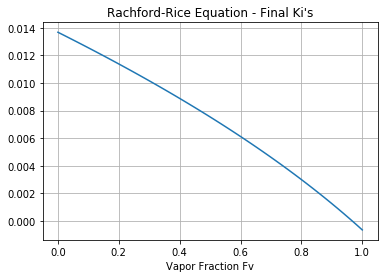

In [36]:
# And plot the associated Rachford-Rice plot
# We can see that we have 96.6% vapor fraction - Just below Dew point at 3,530psi
ncomps = len(comps)
Fv_plot = np.linspace(0,1)
plt.plot(Fv_plot,[sum(z[i]*(Ki[i]-1)/(1+Fv_plot*(Ki[i]-1)) for i in range(ncomps)) for Fv_plot in Fv_plot])
plt.xlabel('Vapor Fraction Fv')
plt.title("Rachford-Rice Equation - Final Ki's")
plt.grid();

In [37]:
# Test Fv at 3,540psia - Slightly above given Pdew
p = 3540 #psia
t = 186+460 #degrees R

# First iteration assumption of Ki's using Wilson approach
Ki = k_wilson(comps, t, p)

Fv, xi, yi, Ki, fi_l, fi_v, Zv, result_table = flash(p,t,comps,z, Ki, 5e-11, 500, 1)

print('Fugacity Iteration Results')
header=['Component', 'yi', 'xi', 'Ki', 'fvi', 'fli', 'fli/fvi']
print(tabulate(result_table,headers=header))

Fugacity Iteration Results
Component    yi                      xi        Ki        fvi                   fli          fli/fvi
-----------  ----------------------  --------  --------  --------------------  -----------  --------------------
Iteration:   0                                 Fv:       0.4950231015539612
N2           0.002202                0.000416  2.317903  9.337149              4.091404     0.438186
CO2          0.001629                0.001968  1.124897  3.837888              5.215326     1.358905
C1           0.878988                0.364655  1.510339  2628.408552           1646.899492  0.626577
C2           0.090801                0.189824  0.845112  158.468119            279.973604   1.76675
C3           0.020907                0.144865  0.584071  24.418248             98.82169     4.047043
iC4          0.001137                0.018095  0.456829  0.985553              7.167225     7.27229
nC4          0.003066                0.064326  0.405343  2.399974              2

In [101]:
# And at 3,540psia, flash solution is 100% vapor
# Validating a dep point pressure between 3,530psi and 3,540 psi, consistent with 3,535psi given